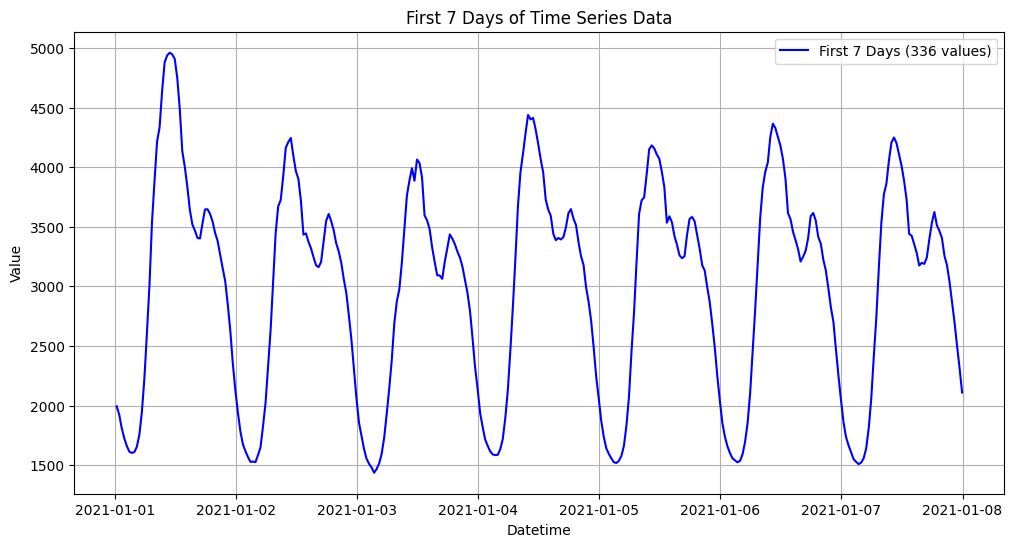

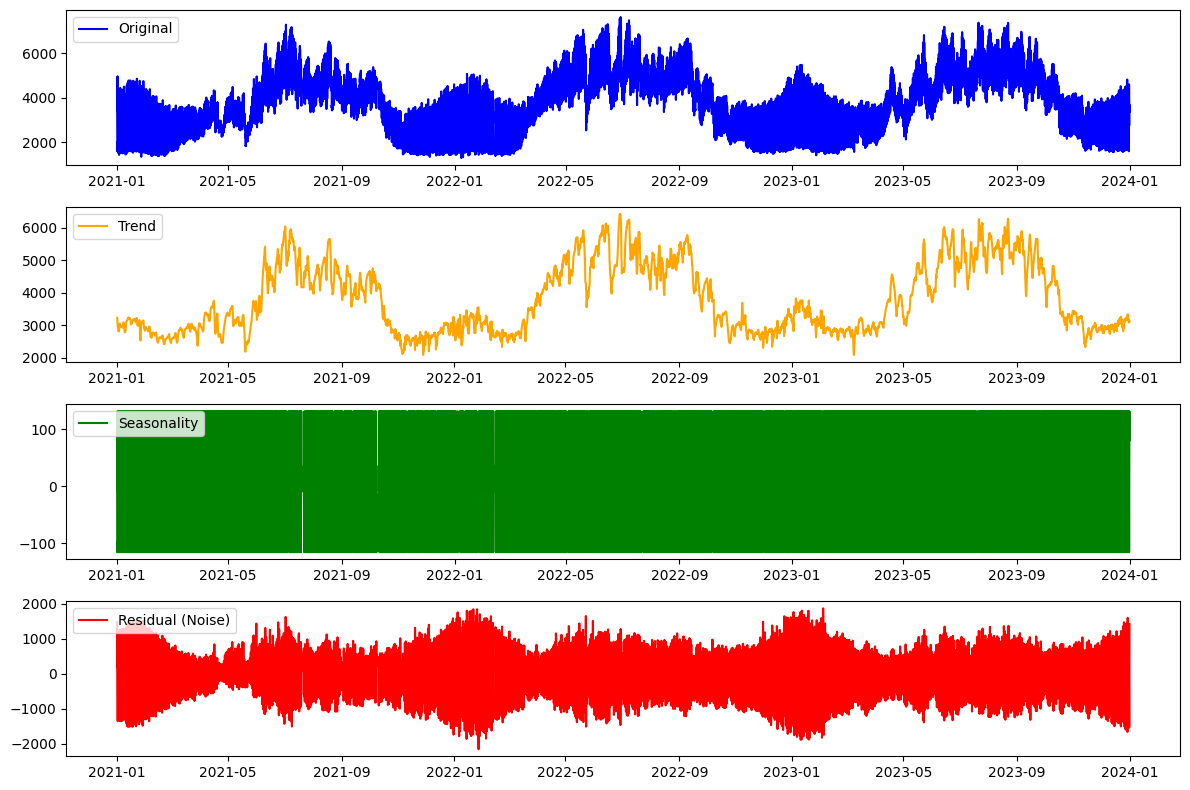

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load your time series data
file_path = '/kaggle/input/processed-file/processed_file.csv'  # Adjust the path to your file
df = pd.read_csv(file_path, parse_dates=['Datetime'], index_col='Datetime')

# Select the target variable
time_series = df['Value']

# Plot the first 7 days of data (48 intervals per day, so 336 points)
weekly_data = time_series[:48*7]

plt.figure(figsize=(12, 6))
plt.plot(weekly_data, label='First 7 Days (336 values)', color='blue')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('First 7 Days of Time Series Data')
plt.legend(loc='upper right')
plt.grid()
plt.show()

# Perform seasonal decomposition on the full dataset
result = seasonal_decompose(time_series, model='additive', period=48)  # Adjust period based on data frequency

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(time_series, label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label='Residual (Noise)', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
df.head()

,Value
Datetime,
2021-01-01 00:25:00,1993.90
2021-01-01 00:55:00,1925.21
2021-01-01 01:25:00,1811.31
2021-01-01 01:55:00,1726.38
2021-01-01 02:25:00,1662.04


Epoch [1/15], Train Loss: 0.0023, Val Loss: 0.0003
Epoch [2/15], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [3/15], Train Loss: 0.0003, Val Loss: 0.0004
Epoch [4/15], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [5/15], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [6/15], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [7/15], Train Loss: 0.0003, Val Loss: 0.0003
Epoch [8/15], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [9/15], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [10/15], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [11/15], Train Loss: 0.0002, Val Loss: 0.0005
Epoch [12/15], Train Loss: 0.0002, Val Loss: 0.0002
Epoch [13/15], Train Loss: 0.0002, Val Loss: 0.0003
Epoch [14/15], Train Loss: 0.0002, Val Loss: 0.0021
Epoch [15/15], Train Loss: 0.0002, Val Loss: 0.0002


/tmp/ipykernel_30/1513433014.py:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


Test R2 Score: 0.9929
Mean Absolute Error (MAE): 62.6473
Root Mean Squared Error (RMSE): 84.3571


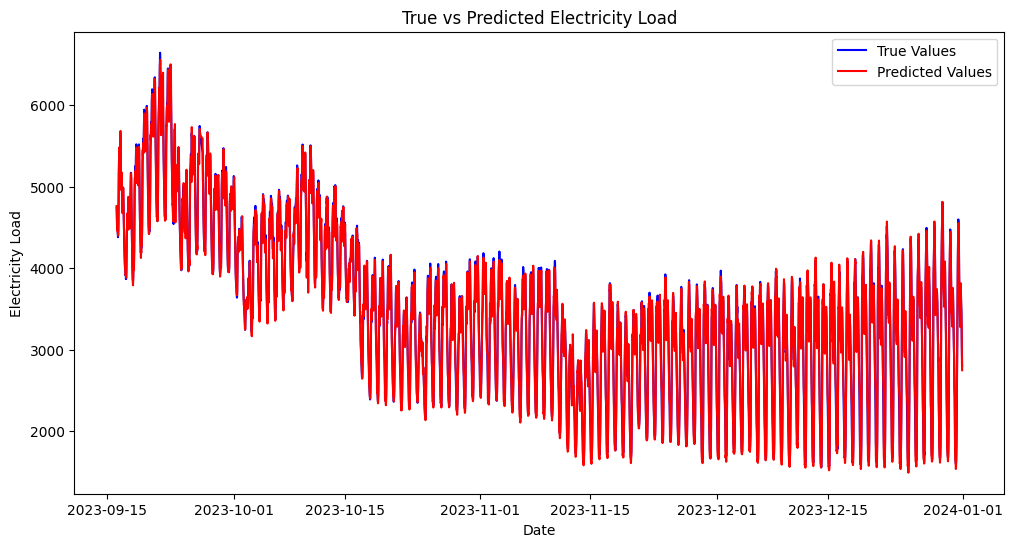

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time

# Load the CSV file (adjust the file path as needed for Kaggle)
file_path = '/kaggle/input/processed-file/processed_file.csv'  # Adjust the path
df = pd.read_csv(file_path, parse_dates=['Datetime'], index_col='Datetime')

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Value']].values)

# Create sequences of data
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 48  # 1 day = 288  intervals
sequences, labels = create_sequences(scaled_data, seq_length)

# Split the data into training, validation, and testing datasets (80% train, 20% validation, 20% test)
X_train, X_temp, y_train, y_temp = train_test_split(sequences, labels, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

# Convert the data into PyTorch tensors and move to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Squeeze the target tensors to remove the extra dimension
y_train_tensor = y_train_tensor.squeeze()
y_val_tensor = y_val_tensor.squeeze()
y_test_tensor = y_test_tensor.squeeze()

# Create TensorDataset and DataLoader for batching
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the LSTM model with 5 layers and hidden size of 256
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=5):
        super(BidirectionalLSTMModel, self).__init__()
        # Set bidirectional=True to use a bidirectional LSTM
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 because of bidirectionality

    def forward(self, x):
        lstm_out, (h_n, c_n) = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Get the output from the last LSTM cell
        return out

# Initialize the model, loss function, and optimizer
input_size = 1  # Only one feature (Value)
hidden_size = 128  # Hidden size
output_size = 1  # We want to predict a single value
model = BidirectionalLSTMModel(input_size, hidden_size, output_size, num_layers=4).to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize variables for tracking best model
best_val_loss = float('inf')
no_improve_count = 0  # Counter to track consecutive epochs where validation loss doesn't improve
patience = 5  # Number of epochs with no improvement before stopping

# Initialize list to store loss values for plotting
train_losses = []
val_losses = []

# Train the LSTM model
epochs = 15

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0

    # Training loop
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        train_loss = criterion(y_pred.squeeze(), y_batch)

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        epoch_train_loss += train_loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    # Validation loop
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss = criterion(y_pred.squeeze(), y_batch)
            epoch_val_loss += val_loss.item()

    epoch_val_loss /= len(val_loader)
    val_losses.append(epoch_val_loss)

    # Check if validation loss improved
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_count = 0
        # Save the model checkpoint with the best validation loss
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve_count += 1

    # Print loss for this epoch
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

    # Early stopping
    # if no_improve_count >= patience:
    #     print("Validation loss didn't improve for 5 consecutive epochs, stopping early.")
    #     break

# Load the best model (after training completes)
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate the model on the test set
model.eval()
y_pred_test = []
y_test_actual = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred_test.append(y_pred.cpu().numpy())
        y_test_actual.append(y_batch.cpu().numpy())

# Convert predictions back to original scale
y_pred_test = scaler.inverse_transform(np.concatenate(y_pred_test))
y_test_actual = scaler.inverse_transform(np.concatenate(y_test_actual).reshape(-1, 1))

# Calculate R2 score
test_r2 = r2_score(y_test_actual, y_pred_test)
print(f"Test R2 Score: {test_r2:.4f}")
mae = mean_absolute_error(y_test_actual, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# Visualize the results
plt.figure(figsize=(12,6))
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='True Values', color='blue')
plt.plot(df.index[-len(y_test_actual):], y_pred_test, label='Predicted Values', color='red')
plt.xlabel('Date')
plt.ylabel('Electricity Load')
plt.legend()
plt.title('True vs Predicted Electricity Load')
plt.show()

